In [ ]:
import pandas as pd
import ast
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, LSTM, Bidirectional, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from itertools import chain
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
train_file_link="https://drive.google.com/file/d/1NY_EEYluQpBSgbrnF7hC4GQmPIKw2_na/view?usp=drive_link"
train_id = train_file_link.split("/")[-2]
new_train_link = f'https://drive.google.com/uc?id={train_id}'
train_df = pd.read_csv(new_train_link)

test_file_link="https://drive.google.com/file/d/17bxSFF_bhSXeE1NcQXfXmW503nmKoDdW/view?usp=drive_link"
test_id = test_file_link.split("/")[-2]
new_test_link = f'https://drive.google.com/uc?id={test_id}'
test_df = pd.read_csv(new_test_link)

In [ ]:
print(train_df.head())
print("\nData types:\n", train_df.dtypes)
print(train_df.isnull().sum())

   Sentence #                                           Sentence  \
0           1  AU officials reported fresh fighting Sunday , ...   
1           2  Also Saturday , in an unrelated development , ...   
2           3  They replied , " We would willingly have helpe...   
3           4          He said he has ordered an investigation .   
4           5  World famous Russian cellist and conductor , M...   

                                                 POS  
0  ['NNP', 'NNS', 'VBD', 'JJ', 'NN', 'NNP', ',', ...  
1  ['RB', 'NNP', ',', 'IN', 'DT', 'JJ', 'NN', ','...  
2  ['PRP', 'VBD', ',', '``', 'PRP', 'MD', 'RB', '...  
3  ['PRP', 'VBD', 'PRP', 'VBZ', 'VBN', 'DT', 'NN'...  
4  ['NNP', 'JJ', 'JJ', 'NN', 'CC', 'NN', ',', 'NN...  

Data types:
 Sentence #     int64
Sentence      object
POS           object
dtype: object
Sentence #    0
Sentence      0
POS           0
dtype: int64


In [ ]:
print("\nTotal entries in each column:\n", train_df.count())
# all_tags = []


Total entries in each column:
 Sentence #    19183
Sentence      19183
POS           19183
dtype: int64


In [ ]:
train_df['POS'] = train_df['POS'].apply(ast.literal_eval)
test_df['POS'] = test_df['POS'].apply(ast.literal_eval)

In [ ]:
train_df['tokens'] = train_df['Sentence'].apply(str.split)

In [ ]:
all_pos_tags = list(chain.from_iterable(train_df['POS']))
print("Total number of POS tags:", len(all_pos_tags))

Total number of POS tags: 418968


In [ ]:
unique_pos_tags = set(all_pos_tags)
print("Unique POS tags:", unique_pos_tags)
print("Number of unique POS tags:", len(unique_pos_tags))

Unique POS tags: {'VBP', 'WP$', 'JJS', '``', 'RP', 'LRB', 'DT', 'RBS', 'CC', 'PDT', 'PRP$', ';', 'UH', 'WDT', ':', 'NN', 'POS', 'VBG', 'EX', 'VBZ', ',', 'WRB', '$', 'RB', 'IN', 'VBN', 'CD', 'TO', 'RBR', '.', 'NNS', 'JJR', 'VBD', 'JJ', 'NNP', 'VB', 'PRP', 'MD', 'WP', 'NNPS', 'RRB'}
Number of unique POS tags: 41


In [ ]:
train_df['sentence_length'] = train_df['Sentence'].apply(lambda x: len(x.split())) # Calculating word count for each sentence
sentence_lengths = train_df.groupby('Sentence')['sentence_length'].sum()

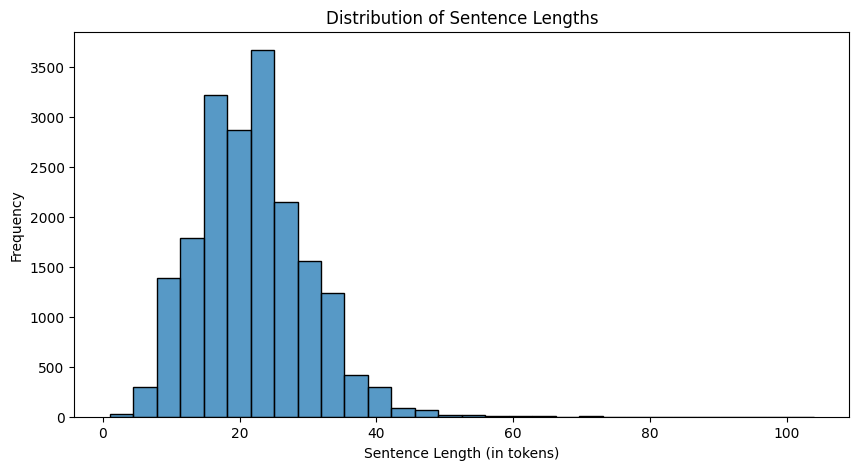

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(sentence_lengths, bins=30, kde=False)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length (in tokens)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Most common words
all_tokens = list(chain.from_iterable(train_df['tokens']))
word_counts = Counter(all_tokens)

# Show the top 10 most common words
print("Most common words:")
print(word_counts.most_common(20))

Most common words:
[('the', 21060), ('.', 19102), (',', 13096), ('in', 10546), ('of', 10452), ('to', 9336), ('a', 8269), ('and', 7953), ('The', 4518), ("'s", 4382), ('for', 3435), ('has', 2916), ('on', 2679), ('is', 2657), ('that', 2494), ('with', 2197), ('have', 2191), ('said', 2109), ('was', 1962), ('says', 1856)]


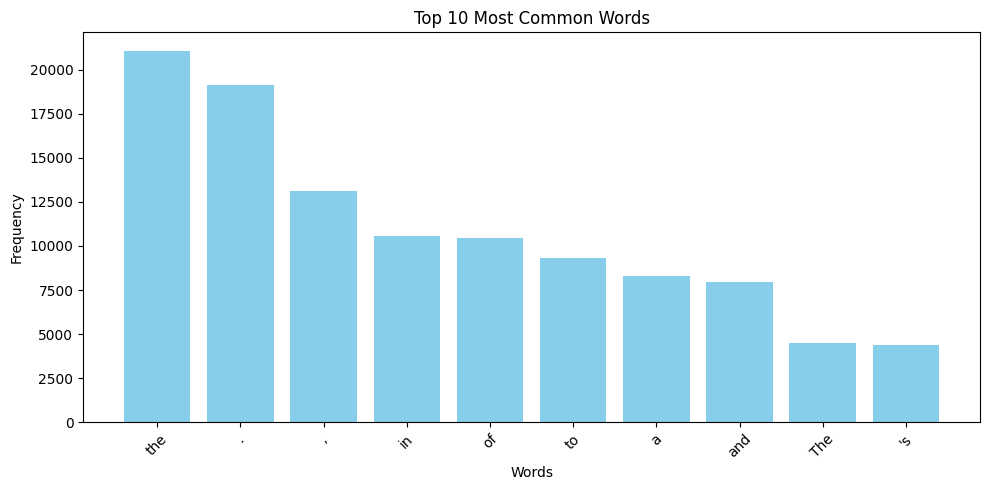

In [ ]:
common_words = word_counts.most_common(10)
words, word_freqs = zip(*common_words)

plt.figure(figsize=(10, 5))
plt.bar(words, word_freqs, color='skyblue')
plt.title('Top 10 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
all_tags = list(chain.from_iterable(train_df['POS']))
tag_counts = Counter(all_tags)

# Show the top 10 most common POS tags
print("Most common POS tags:")
print(tag_counts.most_common(20))

Most common POS tags:
[('NN', 58417), ('NNP', 52470), ('IN', 48224), ('DT', 39573), ('JJ', 31267), ('NNS', 30299), ('.', 19129), ('VBD', 15672), (',', 13099), ('VBN', 13002), ('VBZ', 9957), ('VB', 9735), ('CD', 9711), ('CC', 9469), ('TO', 9266), ('RB', 8101), ('VBG', 7714), ('VBP', 6548), ('PRP', 5311), ('POS', 4529)]


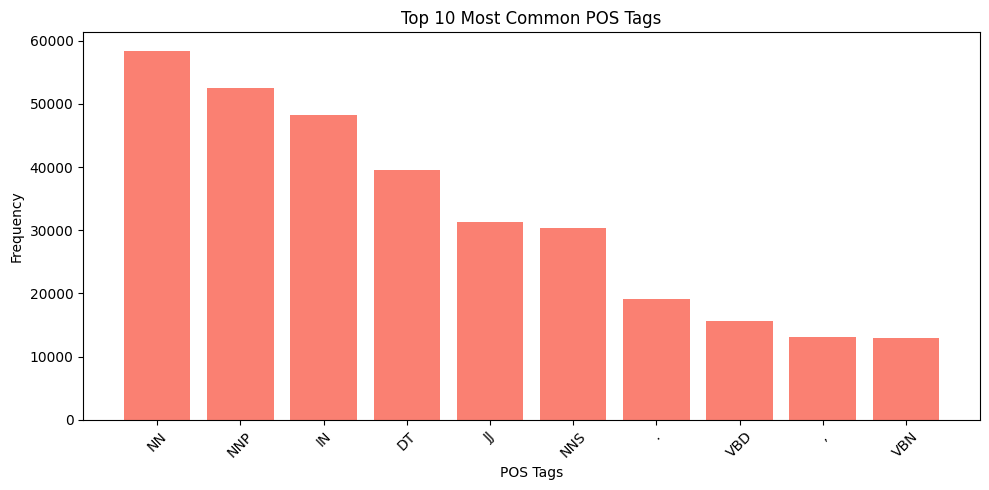

In [ ]:
# Most common POS tags
common_tags = tag_counts.most_common(10)
tags, tag_freqs = zip(*common_tags)

plt.figure(figsize=(10, 5))
plt.bar(tags, tag_freqs, color='salmon')
plt.title('Top 10 Most Common POS Tags')
plt.xlabel('POS Tags')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
mismatch_rows = [(i, len(w), len(t)) for i, (w, t) in enumerate(zip(train_df['tokens'], train_df['POS'])) if len(w) != len(t)]
if mismatch_rows:
    print(f"Found {len(mismatch_rows)} mismatched rows (token count ≠ tag count)")
    for i, token_len, tag_len in mismatch_rows[:5]:  # show first 5
        print(f"Row {i} — Tokens: {token_len}, Tags: {tag_len}")
    train_df = train_df[[len(w) == len(t) for w, t in zip(train_df['tokens'], train_df['POS'])]]

Found 3 mismatched rows (token count ≠ tag count)
Row 8626 — Tokens: 52, Tags: 54
Row 10197 — Tokens: 37, Tags: 38
Row 12343 — Tokens: 28, Tags: 29


In [ ]:
train_df.shape

(19180, 5)

In [ ]:
word_tokenizer = Tokenizer(lower=False, oov_token='<OOV>')
word_tokenizer.fit_on_texts(train_df['tokens'])

tag_encoder = LabelEncoder()
tag_encoder.fit([tag for tags in train_df['POS'] for tag in tags])

X_train_seq = word_tokenizer.texts_to_sequences(train_df['tokens'])
X_test_seq = word_tokenizer.texts_to_sequences(test_df['Sentence'].apply(str.split))

y_train_seq = [[tag_encoder.transform([tag])[0] for tag in tags] for tags in train_df['POS']]
y_test_seq = [[tag_encoder.transform([tag])[0] for tag in tags] for tags in test_df['POS']]


In [ ]:
MAX_LEN = max([len(seq) for seq in X_train_seq])

X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

y_train_padded = pad_sequences(y_train_seq, maxlen=MAX_LEN, padding='post')
y_test_padded = pad_sequences(y_test_seq, maxlen=MAX_LEN, padding='post')

In [ ]:
num_tags = len(tag_encoder.classes_)

y_train_cat = to_categorical(y_train_padded, num_classes=num_tags)
y_test_cat = to_categorical(y_test_padded, num_classes=num_tags)

In [ ]:
from sklearn.model_selection import train_test_split

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_padded, y_train_cat, test_size=0.1, random_state=42
)

# **RNN**

In [ ]:
#RNN

vocab_size = len(word_tokenizer.word_index) + 1
embedding_dim = 300
rnn_units = 32
batch_size = 256
epochs = 15

rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=MAX_LEN))
rnn_model.add(SimpleRNN(units=rnn_units, return_sequences=True))
rnn_model.add(TimeDistributed(Dense(num_tags, activation='softmax')))

rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_rnn = rnn_model.fit(X_train_final, y_train_final, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[early_stop])

rnn_model.summary()

y_pred = rnn_model.predict(X_test_padded)
y_pred_labels = np.argmax(y_pred, axis=-1)
y_true_labels = np.argmax(y_test_cat, axis=-1)

y_pred_flat = []
y_true_flat = []

for i in range(len(y_true_labels)):
    for j in range(len(y_true_labels[i])):
        if y_true_labels[i][j] != 0:
            y_true_flat.append(y_true_labels[i][j])
            y_pred_flat.append(y_pred_labels[i][j])

labels = list(range(len(tag_encoder.classes_)))
print(classification_report(y_true_flat, y_pred_flat, labels=labels, target_names=tag_encoder.classes_))

f1_rnn = f1_score(y_true_flat, y_pred_flat, average='macro')
print("Macro F1-score:", f1_rnn)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 534ms/step - accuracy: 0.7601 - loss: 1.4801 - val_accuracy: 0.9311 - val_loss: 0.5080
Epoch 2/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9379 - loss: 0.4540 - val_accuracy: 0.9581 - val_loss: 0.3028
Epoch 3/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9636 - loss: 0.2714 - val_accuracy: 0.9751 - val_loss: 0.1913
Epoch 4/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9787 - loss: 0.1707 - val_accuracy: 0.9822 - val_loss: 0.1300
Epoch 5/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9856 - loss: 0.1149 - val_accuracy: 0.9858 - val_loss: 0.0960
Epoch 6/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9897 - loss: 0.0814 - val_accuracy: 0.9877 - val_loss: 0.0761
Epoch 7/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9918 - loss: 0.0623 - val_accuracy: 0.9887 - val_loss: 0.0638
Epoch 8/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9932 - loss: 0.0489 - val_accuracy: 0.9895 -

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 104, 300)       │     6,870,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 104, 32)        │        10,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 104, 41)        │         1,353 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,648,729 (78.77 MB)

 Trainable params: 6,882,909 (26.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,765,820 (52.51 MB)

150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step
              precision    recall  f1-score   support

           $       0.00      0.00      0.00         0
           ,       1.00      1.00      1.00      3314
           .       1.00      1.00      1.00      4789
           :       0.51      0.67      0.58        73
           ;       1.00      1.00      1.00        22
          CC       1.00      1.00      1.00      2474
          CD       0.94      0.96      0.95      2522
          DT       1.00      1.00      1.00      9797
          EX       0.91      1.00      0.96        75
          IN       0.97      0.99      0.98     12190
          JJ       0.92      0.89      0.91      7807
         JJR       0.85      0.96      0.90       291
         JJS       0.90      0.94      0.92       309
         LRB       1.00      1.00      1.00        67
          MD       0.99      1.00      1.00       734
          NN       0.93      0.96      0.94     14705
         NNP       0.95      0.96     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)

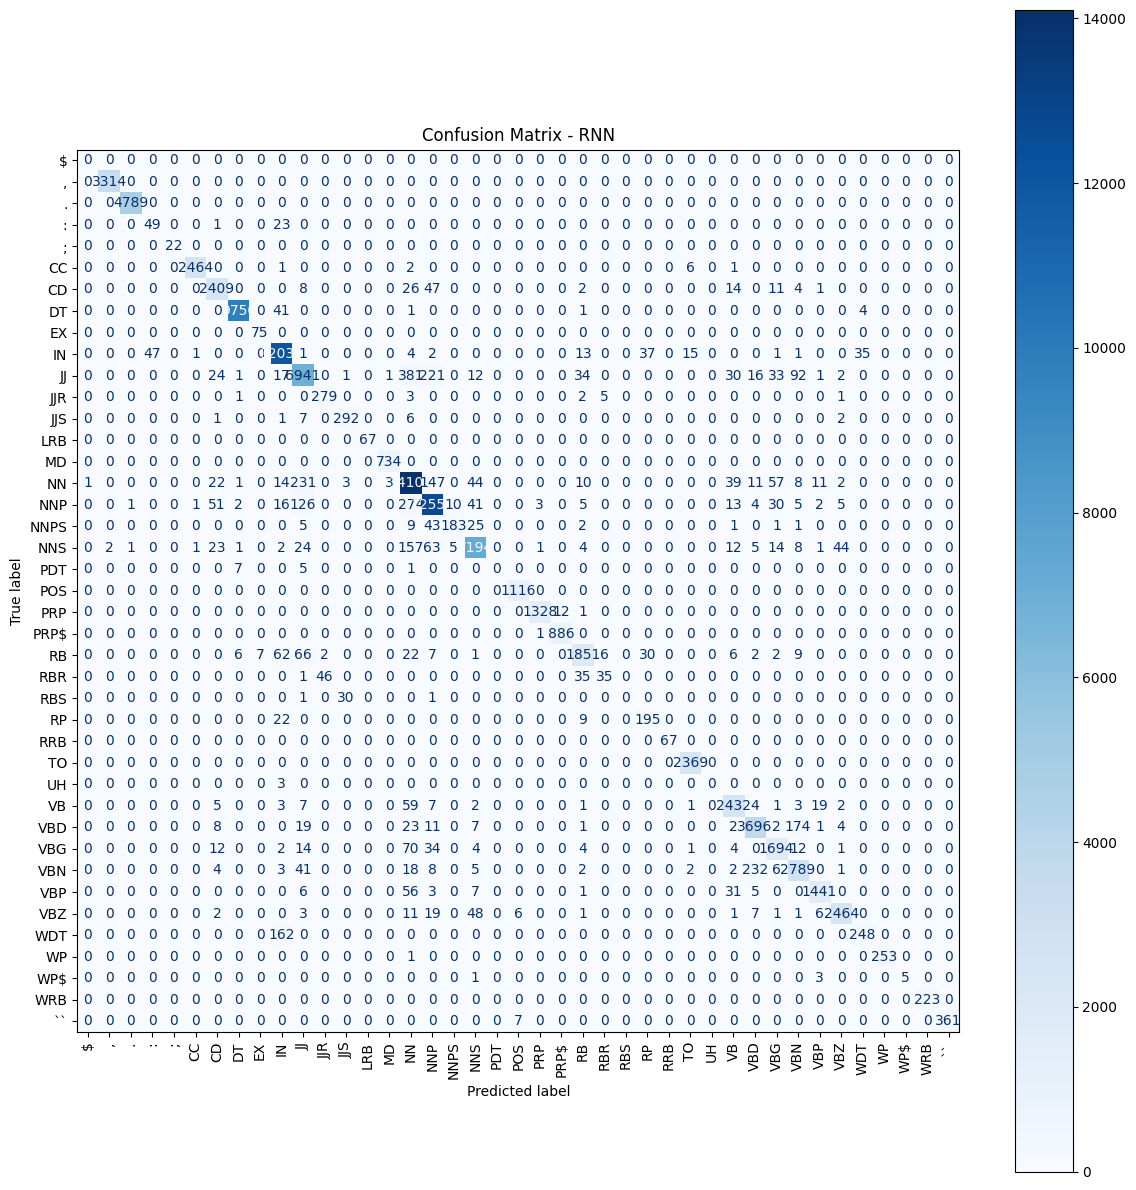

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tag_encoder.classes_)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(include_values=True, xticks_rotation=90, ax=ax, cmap='Blues')
plt.title("Confusion Matrix - RNN")
plt.tight_layout()
plt.show()

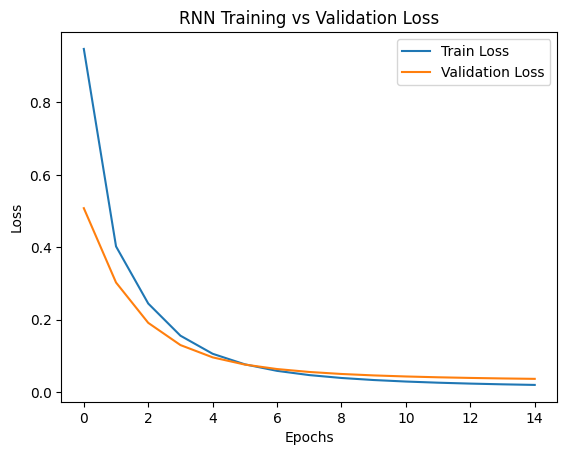

In [ ]:
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('RNN Training vs Validation Loss')
plt.show()

# **GRU**

In [ ]:
# GRU

vocab_size = len(word_tokenizer.word_index) + 1
embedding_dim = 300
gru_units = 32
batch_size = 256
epochs = 15

gru_model = Sequential()
gru_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=MAX_LEN))
gru_model.add(GRU(units=gru_units, return_sequences=True))
gru_model.add(TimeDistributed(Dense(num_tags, activation='softmax')))

gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_gru = gru_model.fit(X_train_final, y_train_final, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[early_stop])

gru_model.summary()

# Predictions and evaluation
y_pred = gru_model.predict(X_test_padded)
y_pred_labels = np.argmax(y_pred, axis=-1)
y_true_labels = np.argmax(y_test_cat, axis=-1)

y_pred_flat = []
y_true_flat = []

for i in range(len(y_true_labels)):
    for j in range(len(y_true_labels[i])):
        if y_true_labels[i][j] != 0:  # Avoid padding
            y_true_flat.append(y_true_labels[i][j])
            y_pred_flat.append(y_pred_labels[i][j])

labels = list(range(len(tag_encoder.classes_)))
print(classification_report(y_true_flat, y_pred_flat, labels=labels, target_names=tag_encoder.classes_))

f1_gru = f1_score(y_true_flat, y_pred_flat, average='macro')
print("Macro F1-score:", f1_gru)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.8379 - loss: 1.1402 - val_accuracy: 0.9393 - val_loss: 0.4025
Epoch 2/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9478 - loss: 0.3423 - val_accuracy: 0.9712 - val_loss: 0.1918
Epoch 3/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9763 - loss: 0.1655 - val_accuracy: 0.9833 - val_loss: 0.1101
Epoch 4/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9869 - loss: 0.0947 - val_accuracy: 0.9871 - val_loss: 0.0761
Epoch 5/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9908 - loss: 0.0630 - val_accuracy: 0.9888 - val_loss: 0.0595
Epoch 6/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9929 - loss: 0.0464 - val_accuracy: 0.9896 - val_loss: 0.0503
Epoch 7/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9938 - loss: 0.0369 - val_accuracy: 0.9899 - val_loss: 0.0445
Epoch 8/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9943 - loss: 0.0308 - val_accuracy: 0.9904 - 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 104, 300)       │     6,870,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 104, 32)        │        32,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 104, 41)        │         1,353 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,712,953 (79.01 MB)

 Trainable params: 6,904,317 (26.34 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,808,636 (52.68 MB)

150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
              precision    recall  f1-score   support

           $       0.00      0.00      0.00         0
           ,       1.00      1.00      1.00      3314
           .       1.00      1.00      1.00      4789
           :       0.55      0.82      0.66        73
           ;       0.96      1.00      0.98        22
          CC       1.00      1.00      1.00      2474
          CD       1.00      0.95      0.97      2522
          DT       1.00      1.00      1.00      9797
          EX       0.87      0.97      0.92        75
          IN       0.98      0.99      0.98     12190
          JJ       0.88      0.91      0.90      7807
         JJR       0.85      0.95      0.90       291
         JJS       0.86      0.97      0.91       309
         LRB       1.00      0.99      0.99        67
          MD       1.00      1.00      1.00       734
          NN       0.95      0.95      0.95     14705
         NNP       0.95      0.96      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

In [ ]:
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)

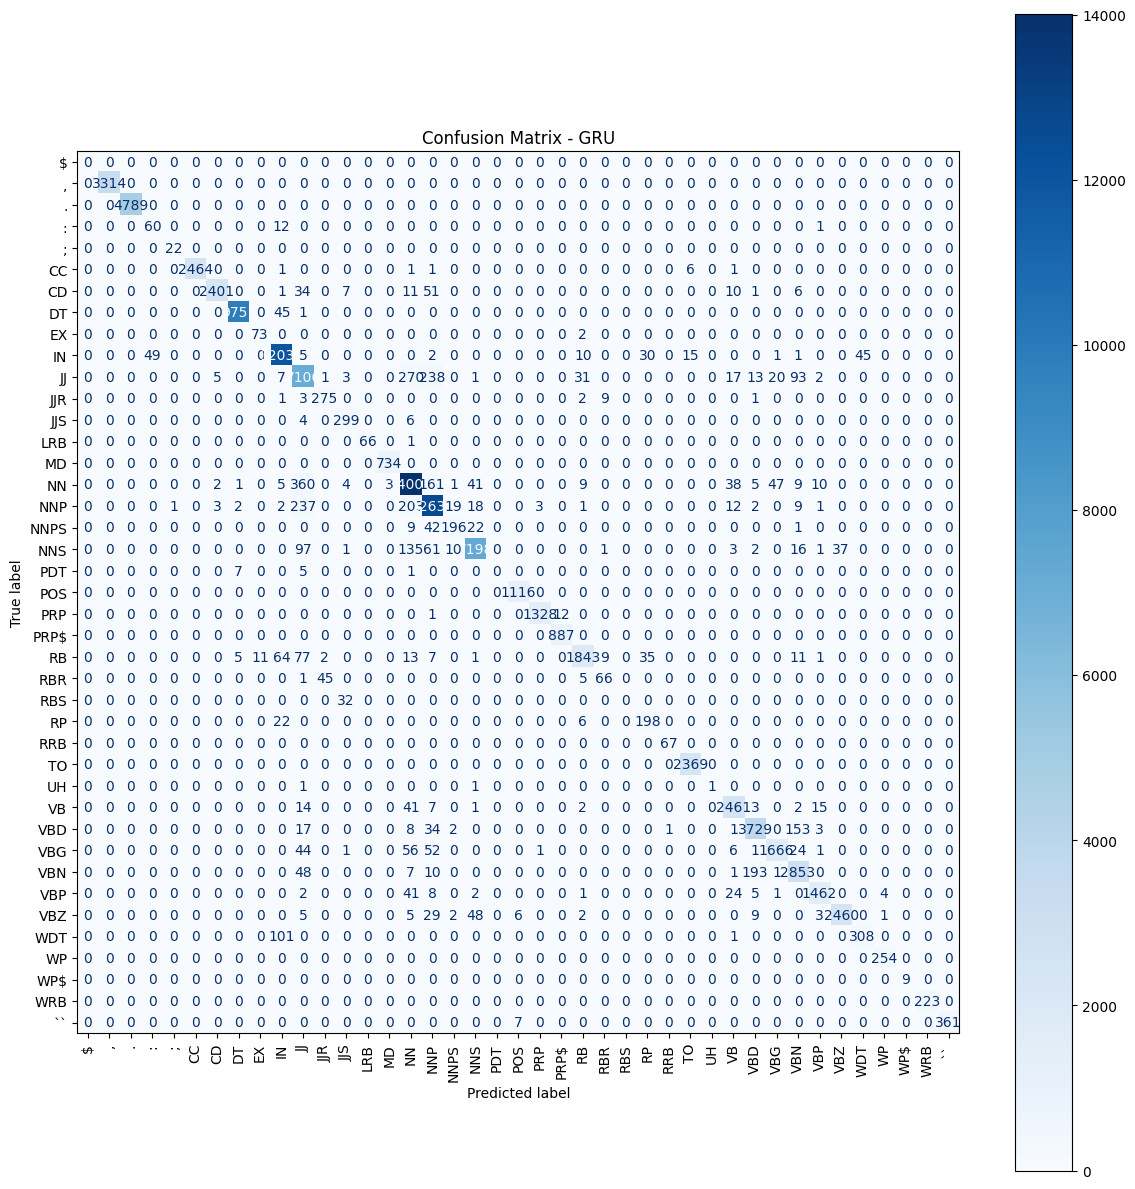

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tag_encoder.classes_)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(include_values=True, xticks_rotation=90, ax=ax, cmap='Blues')
plt.title("Confusion Matrix - GRU")
plt.tight_layout()
plt.show()

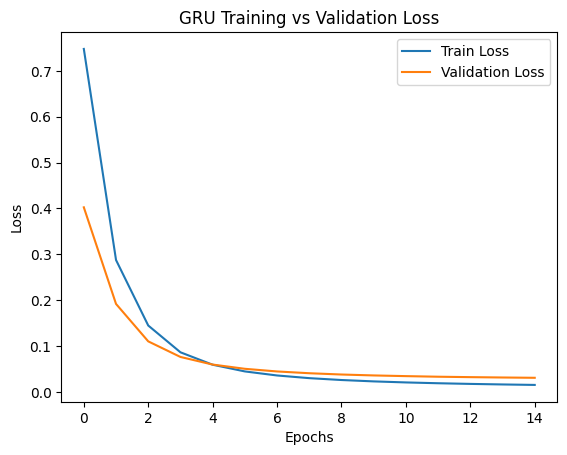

In [ ]:
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('GRU Training vs Validation Loss')
plt.show()

# **LSTM**

In [ ]:
#LSTM

vocab_size = len(word_tokenizer.word_index) + 1
embedding_dim = 300
lstm_units = 32
batch_size = 256
epochs = 15

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=MAX_LEN))
lstm_model.add(LSTM(units=lstm_units, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(num_tags, activation='softmax')))

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_lstm = lstm_model.fit(X_train_final, y_train_final, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[early_stop])

lstm_model.summary()

y_pred = lstm_model.predict(X_test_padded)
y_pred_labels = np.argmax(y_pred, axis=-1)
y_true_labels = np.argmax(y_test_cat, axis=-1)

y_pred_flat = []
y_true_flat = []

for i in range(len(y_true_labels)):
    for j in range(len(y_true_labels[i])):
        if y_true_labels[i][j] != 0:  # Ignore padding
            y_true_flat.append(y_true_labels[i][j])
            y_pred_flat.append(y_pred_labels[i][j])

labels = list(range(len(tag_encoder.classes_)))
print(classification_report(y_true_flat, y_pred_flat, labels=labels, target_names=tag_encoder.classes_))

f1_lstm = f1_score(y_true_flat, y_pred_flat, average='macro')
print("Macro F1-score:", f1_lstm)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.7861 - loss: 1.4178 - val_accuracy: 0.8769 - val_loss: 0.5701
Epoch 2/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8909 - loss: 0.5210 - val_accuracy: 0.9279 - val_loss: 0.3648
Epoch 3/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9347 - loss: 0.3340 - val_accuracy: 0.9549 - val_loss: 0.2394
Epoch 4/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9597 - loss: 0.2199 - val_accuracy: 0.9731 - val_loss: 0.1630
Epoch 5/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9777 - loss: 0.1470 - val_accuracy: 0.9818 - val_loss: 0.1169
Epoch 6/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9860 - loss: 0.1034 - val_accuracy: 0.9858 - val_loss: 0.0892
Epoch 7/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9899 - loss: 0.0763 - val_accuracy: 0.9877 - val_loss: 0.0722
Epoch 8/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9919 - loss: 0.0599 - val_accuracy: 0.9888 - 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 104, 300)       │     6,870,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 104, 32)        │        42,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 104, 41)        │         1,353 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,744,633 (79.13 MB)

 Trainable params: 6,914,877 (26.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,829,756 (52.76 MB)

150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
              precision    recall  f1-score   support

           $       0.00      0.00      0.00         0
           ,       1.00      1.00      1.00      3314
           .       1.00      1.00      1.00      4789
           :       1.00      0.01      0.03        73
           ;       1.00      1.00      1.00        22
          CC       1.00      1.00      1.00      2474
          CD       0.98      0.95      0.96      2522
          DT       1.00      1.00      1.00      9797
          EX       0.84      1.00      0.91        75
          IN       0.98      0.99      0.98     12190
          JJ       0.93      0.89      0.91      7807
         JJR       0.84      0.93      0.89       291
         JJS       0.90      0.95      0.92       309
         LRB       1.00      0.97      0.98        67
          MD       1.00      1.00      1.00       734
          NN       0.93      0.96      0.95     14705
         NNP       0.94      0.97      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)

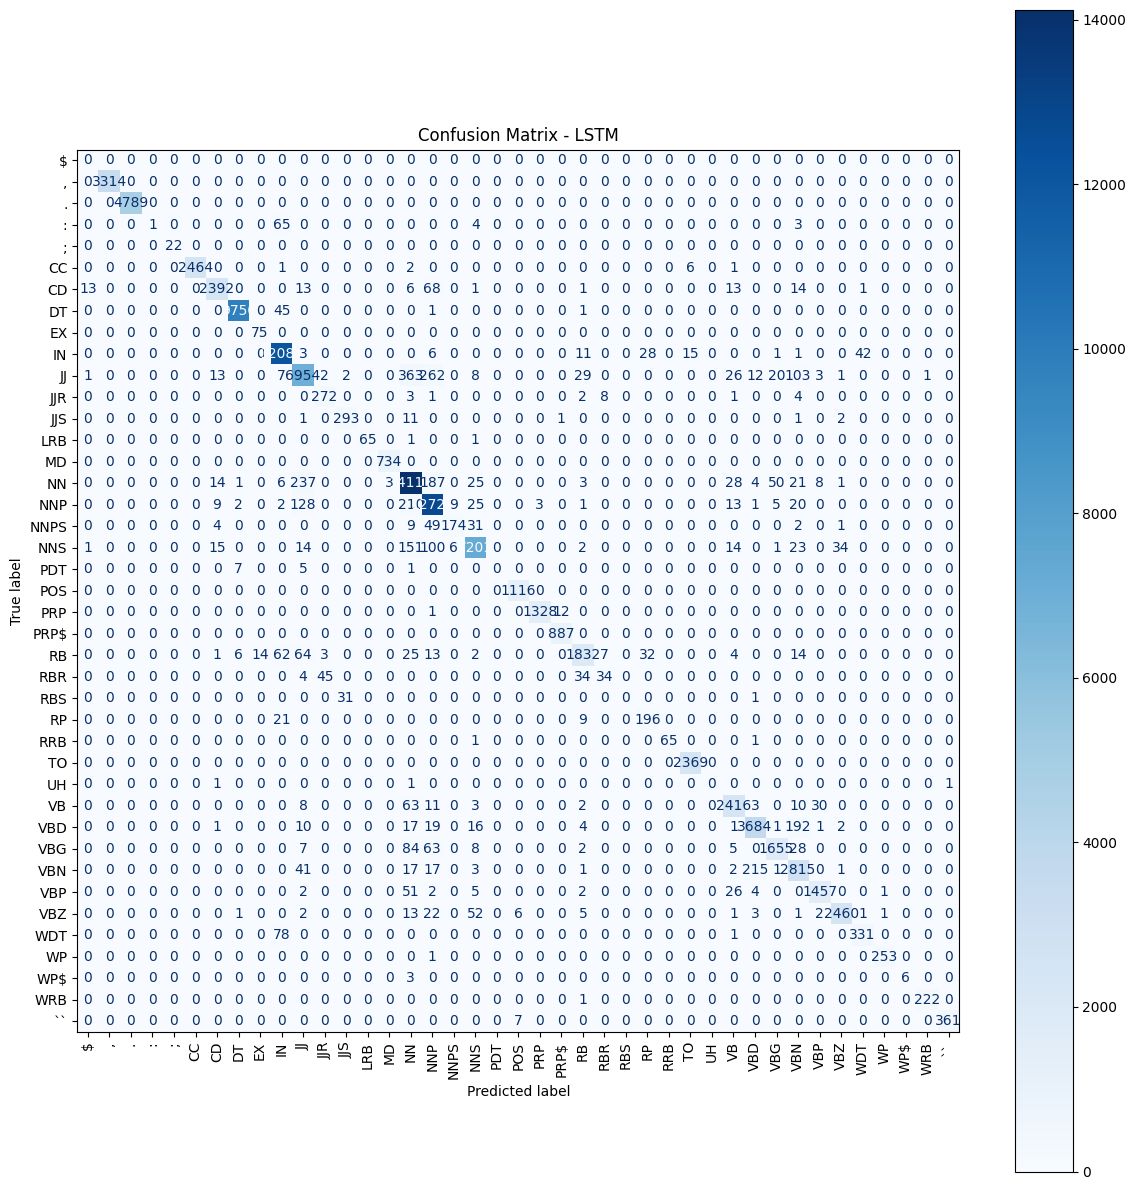

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tag_encoder.classes_)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(include_values=True, xticks_rotation=90, ax=ax, cmap='Blues')
plt.title("Confusion Matrix - LSTM")
plt.tight_layout()
plt.show()

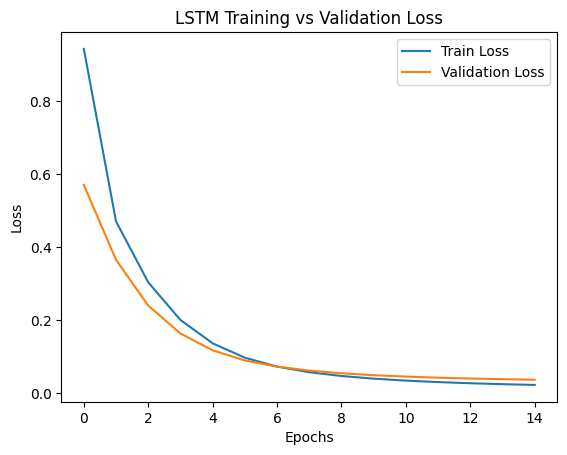

In [ ]:
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training vs Validation Loss')
plt.show()

# **BiLSTM**

In [ ]:
#BiLSTM

vocab_size = len(word_tokenizer.word_index) + 1
embedding_dim = 300
bilstm_units = 32
batch_size = 256
epochs = 15

bilstm_model = Sequential()
bilstm_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=MAX_LEN))
bilstm_model.add(Bidirectional(LSTM(units=bilstm_units, return_sequences=True)))
bilstm_model.add(TimeDistributed(Dense(num_tags, activation='softmax')))

bilstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_bilstm = bilstm_model.fit(X_train_final, y_train_final, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[early_stop])

bilstm_model.summary()

y_pred = bilstm_model.predict(X_test_padded)
y_pred_labels = np.argmax(y_pred, axis=-1)
y_true_labels = np.argmax(y_test_cat, axis=-1)

y_pred_flat = []
y_true_flat = []

for i in range(len(y_true_labels)):
    for j in range(len(y_true_labels[i])):
        if y_true_labels[i][j] != 0:
            y_true_flat.append(y_true_labels[i][j])
            y_pred_flat.append(y_pred_labels[i][j])

labels = list(range(len(tag_encoder.classes_)))
print(classification_report(y_true_flat, y_pred_flat, labels=labels, target_names=tag_encoder.classes_))

f1_bilstm = f1_score(y_true_flat, y_pred_flat, average='macro')
print("Macro F1-score:", f1_bilstm)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.7608 - loss: 1.0943 - val_accuracy: 0.8965 - val_loss: 0.4359
Epoch 2/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9062 - loss: 0.3875 - val_accuracy: 0.9447 - val_loss: 0.2428
Epoch 3/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9542 - loss: 0.2123 - val_accuracy: 0.9745 - val_loss: 0.1319
Epoch 4/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9787 - loss: 0.1149 - val_accuracy: 0.9846 - val_loss: 0.0801
Epoch 5/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9882 - loss: 0.0682 - val_accuracy: 0.9881 - val_loss: 0.0563
Epoch 6/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9919 - loss: 0.0455 - val_accuracy: 0.9901 - val_loss: 0.0441
Epoch 7/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9939 - loss: 0.0328 - val_accuracy: 0.9912 - val_loss: 0.0372
Epoch 8/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9951 - loss: 0.0258 - val_accuracy: 0.9920 - 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 104, 300)       │     6,870,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 104, 64)        │        85,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 104, 41)        │         2,665 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,876,441 (79.64 MB)

 Trainable params: 6,958,813 (26.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,917,628 (53.09 MB)

150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
              precision    recall  f1-score   support

           $       0.00      0.00      0.00         0
           ,       1.00      1.00      1.00      3314
           .       1.00      1.00      1.00      4789
           :       0.70      0.74      0.72        73
           ;       1.00      1.00      1.00        22
          CC       1.00      1.00      1.00      2474
          CD       1.00      0.95      0.97      2522
          DT       1.00      1.00      1.00      9797
          EX       0.86      0.99      0.92        75
          IN       0.99      0.99      0.99     12190
          JJ       0.92      0.95      0.94      7807
         JJR       0.85      0.94      0.89       291
         JJS       0.92      0.94      0.93       309
         LRB       1.00      0.97      0.98        67
          MD       1.00      1.00      1.00       734
          NN       0.95      0.97      0.96     14705
         NNP       0.96      0.97      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)

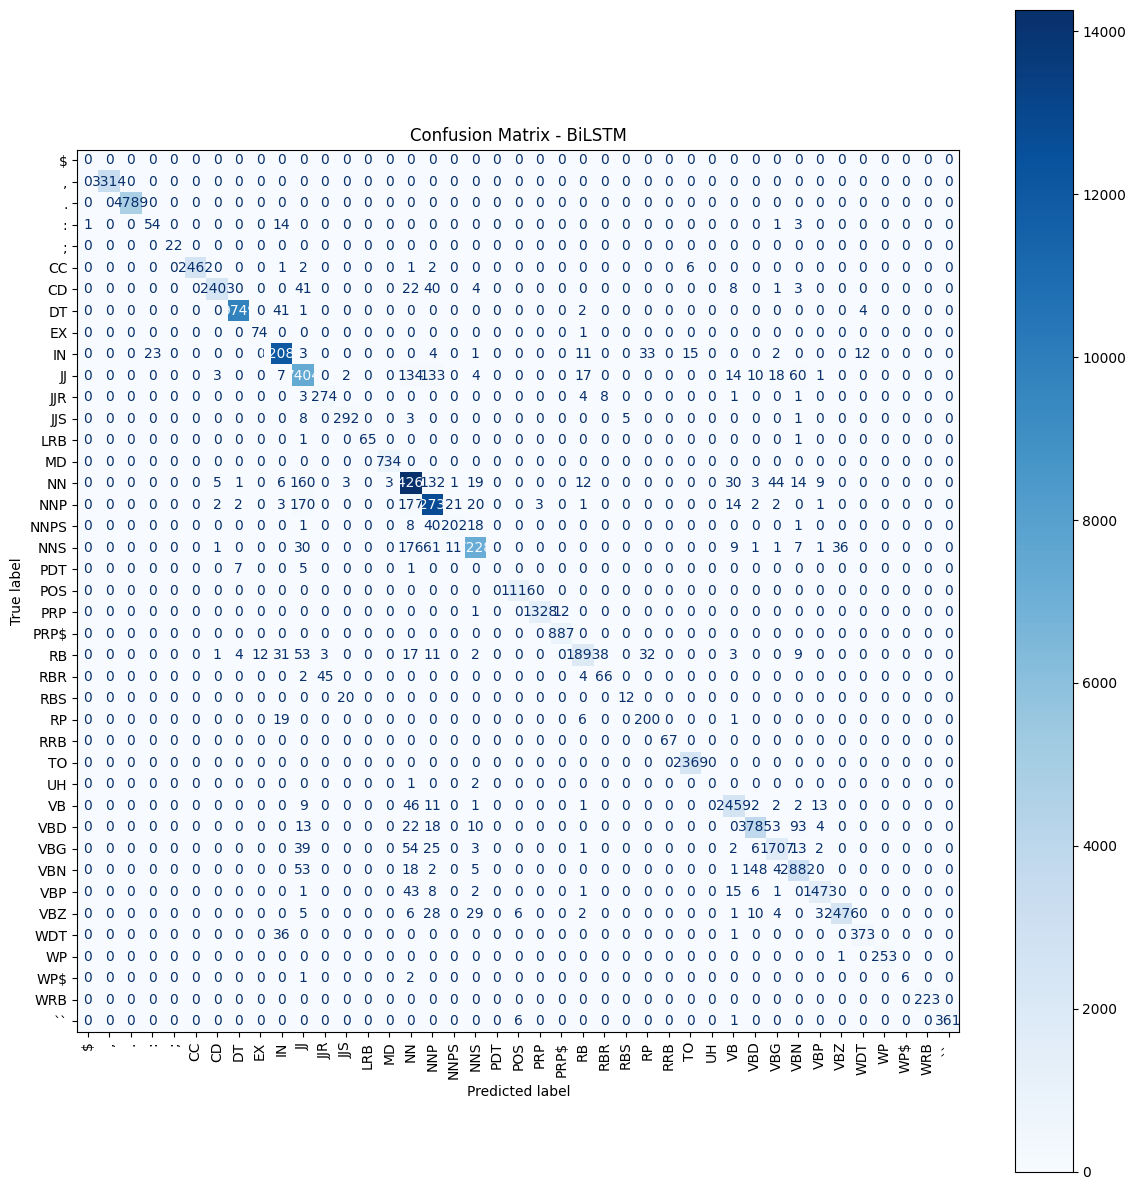

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tag_encoder.classes_)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(include_values=True, xticks_rotation=90, ax=ax, cmap='Blues')
plt.title("Confusion Matrix - BiLSTM")
plt.tight_layout()
plt.show()

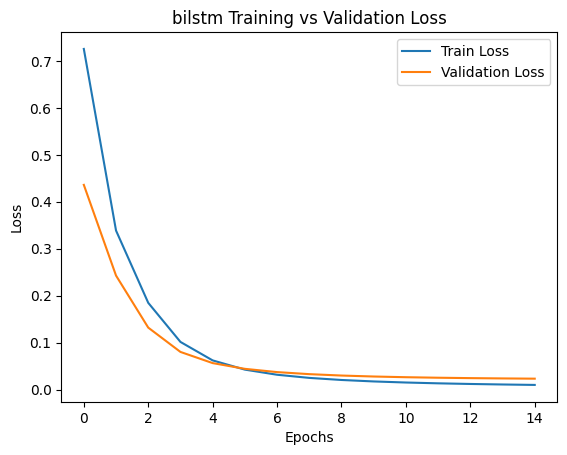

In [ ]:
plt.plot(history_bilstm.history['loss'], label='Train Loss')
plt.plot(history_bilstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('bilstm Training vs Validation Loss')
plt.show()

In [ ]:
val_acc_rnn = max(history_rnn.history['val_accuracy'])
val_acc_gru = max(history_gru.history['val_accuracy'])
val_acc_lstm = max(history_lstm.history['val_accuracy'])
val_acc_bilstm = max(history_bilstm.history['val_accuracy'])

## **Model comparison graph**

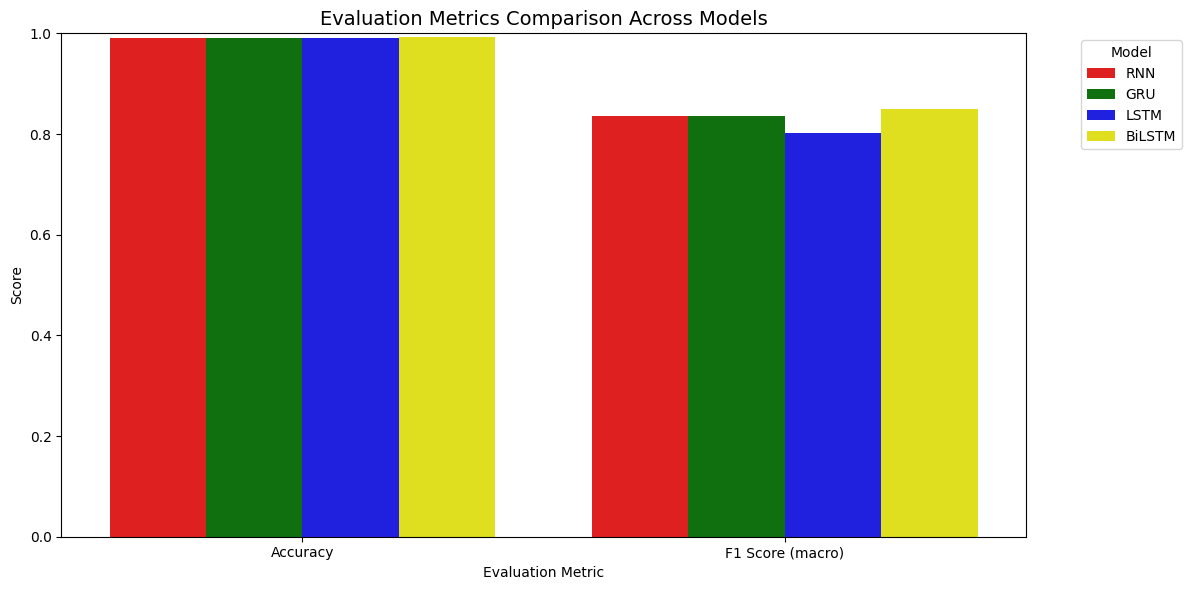

In [ ]:
data = {
    'Model': ['RNN', 'GRU', 'LSTM', 'BiLSTM'],
    'Accuracy': [val_acc_rnn, val_acc_gru, val_acc_lstm, val_acc_bilstm],
    'F1 Score (macro)': [0.835, 0.836, 0.803, 0.849]
}

df = pd.DataFrame(data)


df_melted = df.melt(id_vars='Model', var_name='Evaluation Metric', value_name='Score')

custom_palette = {
    'RNN': 'red',
    'GRU': 'green',
    'LSTM': 'blue',
    'BiLSTM': 'yellow'
}

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='Evaluation Metric', y='Score', hue='Model', palette=custom_palette)

plt.title('Evaluation Metrics Comparison Across Models', fontsize=14)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('Evaluation Metric')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
